# Exploratory data analysis with Bach's chorales
## (Why being an alto sucks, and why I wouldn't trade it for the world.)

This music analysis project uses [the music21 package](http://web.mit.edu/music21/). One on my main motivations was to check whether, as popular choir wisdom has it, "altos always sing Gs", and why that is. I studied the complete Bach chorales from a statistical point of view to understand each voice's role in the harmony, why some parts always seemed more varied than others, and whether altos were truly irredeemable.

(Disclaimer: I'm not a musicologist. If you are one, and disagree with my interpretation or have insight you want to share, please get in touch.)


### Part I: exploratory analysis
<ul>
    <li><a href='#data'> Fetching the data </a> : a quick explanation of what data I chose and how</li>
    <li><a href="#global">Global analysis</a>: what are Bach's favorite pitches and keys?</li>
    <li><a href="#by_part">Analysis per voice</a>: which voices vary the least? the most? how different are they, statistically?</li>    
</ul>


Note: following `music21`'s standard, I write flat notes with a - instead of a b, to avoid confusion. Sharp notes are still denoted with a #.

## Imports and helper functions

In [1]:
%matplotlib inline

In [2]:
import music21 as msc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set_theme(style='darkgrid')

In [3]:
def play_midi(stream):
    msc.midi.realtime.StreamPlayer(stream).play()

---
<div id='data'></div>
    
## Fetching the data
`music21` is shipped with a corpus containing all Bach chorales. I parse each of these in turn and store the most relevant information in a dataframe. 
The different pitches are stored under three forms: `pitch_class` which is the note "number" (0 for C, 1 for C#... all the way to 11), `pitch_name` which has the full name of the pitch, including the octave, and `pitch_midi` which is the midi code corresponding to a note (an integer between 0 and 127, indicating the height of the note where middle C is 60, C#/D- is 61 etc). While the `pitch_name` distinguishes between, say, an F# and a G-, the other two values do not.

As a first approximation, I am dropping rhythm/duration information and only focusing on pitch.

I'm also keeping track of the key, and of course of the piece name, and parts. 



Here's the code:

```python
voices = ['Soprano', 'Alto', 'Tenor', 'Bass']
df = pd.DataFrame(columns=['piece', 'key', 'part', 'pitch_class', 'pitch_name', 'pitch_midi'])

all_bach = msc.corpus.search('bach', 'composer')
i=0
tic = time.time()

for piece in all_bach:
    score = msc.corpus.parse(piece)

    if all([part.partName in voices for part in score.getElementsByClass('Part')]):
        i += 1
        if i % 10 == 0:
            print(f"processed {i}")
        
        for part in score.getElementsByClass('Part'):
            title = score.metadata.title
            key = score.analyze('key')
            part_name = part.partName
            df_temp = pd.DataFrame(([[title, key, part_name, note.pitch.pitchClass, note.pitch.nameWithOctave, note.pitch.midi] 
                                     for note in part.recurse().getElementsByClass('Note')]),
                                   columns=['piece', 'key', 'part', 'pitch_class', 'pitch_name', 'pitch_midi'])
            df = df.append(df_temp, ignore_index=True)

print(f'processed {i} scores in {time.time() - tic} seconds.')

df.to_csv('bach.csv', index=False)
```

I want to focus on pitch distribution across voices; there are two (imo) interesting points of view here:
 - in terms of 'absolute' pitches, how are they distributed, and which parts show the most/least variation. One would expect that different voices have different average pitches and that the standard deviation is roughly the same for everybody (OK, that last one is _clearly_ wishful thinking, we all know altos will have negligible standard deviation).
 - in terms of 'relative', once everything is transposed to the same key

In [4]:
df = pd.read_csv('bach.csv')

---
<div id='global'></div>

## Scales and pitches
What's Bach's favorite pitch? Throughout, I use the `midi` pitch representation: it is numerical (so we can compute averages and variances) and gives octave information. As an indication, $60$ is a mid C (C4), $61$ is C#4 etc. If we're only looking at the pitch class (the "name of the note"), then 0 corresponds to C, 1 to C#/D- etc.

In [5]:
unique = len(df['pitch_midi'].unique())
top_pitch = msc.pitch.Pitch(midi=df['pitch_midi'].mode()[0])
avg_pitch = msc.pitch.Pitch(midi=np.round(df['pitch_midi'].mean()))
min_pitch = msc.pitch.Pitch(midi=df['pitch_midi'].min())
max_pitch = msc.pitch.Pitch(midi=df['pitch_midi'].max())

print(f"Distinct pitches: \t{unique}"
      f"\nLowest pitch: \t\t{min_pitch}"
      f"\nHighest pitch: \t\t{max_pitch}"
      f"\nMost frequent pitch: \t{top_pitch}"
      f"\nAverage pitch: \t\t{avg_pitch}")

Distinct pitches: 	45
Lowest pitch: 		C2
Highest pitch: 		A5
Most frequent pitch: 	D4
Average pitch: 		C#4


The chorales are spread over 45 pitches; the most frequent one is 62, that is, D4, and the average pitch is a C#4.

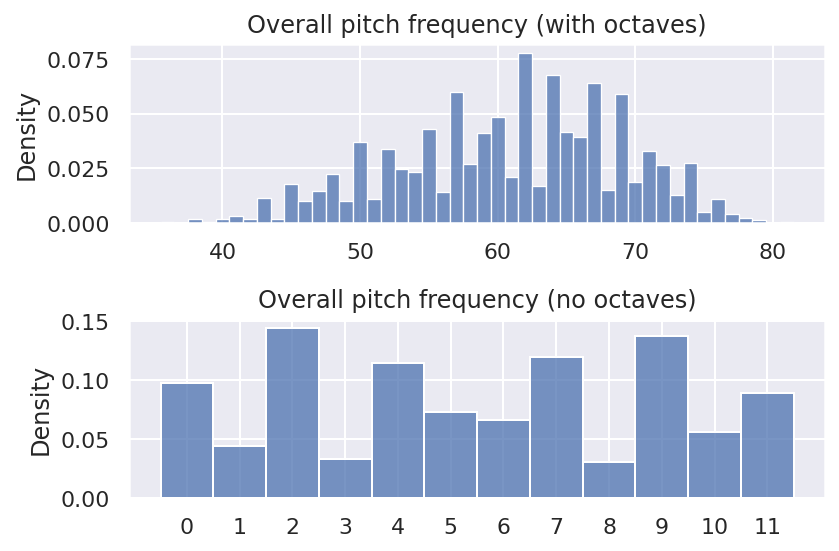

In [6]:
fig, axes = plt.subplots(2, 1)

ax1, ax2 = axes.flat

sns.histplot(data=df['pitch_midi'], ax=ax1, discrete=True, stat='density')
ax1.set(title='Overall pitch frequency (with octaves)', xlabel='');

sns.histplot(data=df['pitch_class'], ax=ax2, discrete=True, stat='density')
ax2.set(title='Overall pitch frequency (no octaves)', xticks=range(12), xlabel='');

fig.tight_layout()

Looking only at pitch class confirms D is Bach's favorite pitch, followed by A and G. His least favorites are G#/Ab, D#/Eb and C#/Db. 

Let's look at keys to see what's up. We'll start by a histogram of key frequencies; to set things up I'm extracting some data from the key: relative scale, number of sharps (this is purely for graphing purposes). I'm putting the code in comments since I saved the corresponding dataframe as a .csv.

```python
df_pieces = df[['piece', 'key']].drop_duplicates()
df_pieces['key'] = df_pieces['key'].apply(lambda x: x.split(' ')[0])
df_pieces['major'] = df_pieces['key'].apply(lambda x: int(x[0].isupper()))

df_pieces['sharps'] = df_pieces['key'].apply(lambda x: msc.key.Key(x).sharps)

df_pieces.to_csv('bach_pieces.csv', index=False)
```

In [7]:
df_pieces = pd.read_csv('bach_pieces.csv')

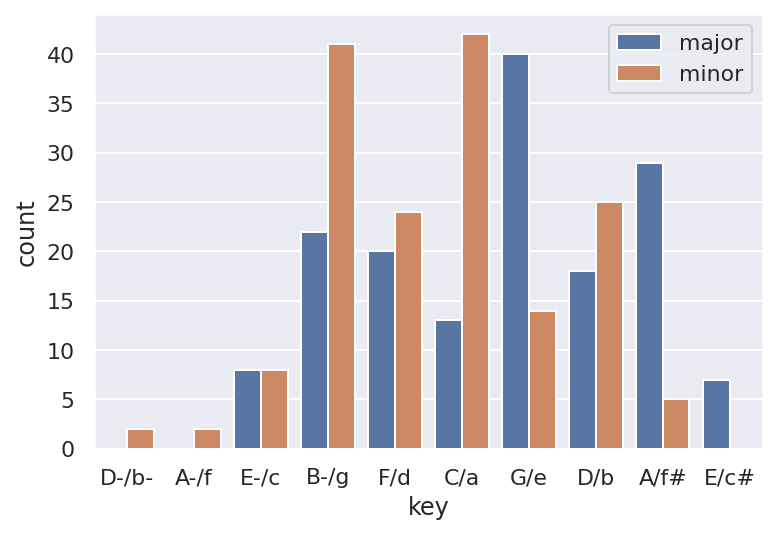

In [8]:
fig, ax = plt.subplots()

sns.countplot(x = 'sharps', data=df_pieces, hue='major',  hue_order=[1,0])
ax.set(xlabel='key', xticklabels=['D-/b-', 'A-/f', 'E-/c', 'B-/g', 'F/d', 'C/a', 'G/e', 'D/b', 'A/f#', 'E/c#'])
ax.legend(['major', 'minor']);

Note that G (minor and major) and A (minor) are pretty high up Bach's favorite key list, which explains why he'd write so many D's, G's and A's. Mystery solved. 

What's up with D# then? Let's look at a list of pitches in each scale, and see in how many cases Bach's least favorite pitch is a part of the scale.

In [9]:
df_pieces['D#_degree'] = df_pieces['key'].apply(lambda x: msc.key.Key(x).getScaleDegreeFromPitch('e-', comparisonAttribute='pitchClass'))
df_pieces['D_degree'] = df_pieces['key'].apply(lambda x: msc.key.Key(x).getScaleDegreeFromPitch('d', comparisonAttribute='pitchClass'))


print(f"Scales with D: \t\t{df_pieces['D_degree'].count() / len(df_pieces) * 100:.0f}%"
      f"\nScales with D#/E-: \t{df_pieces['D#_degree'].count() / len(df_pieces) * 100:.0f}%")

print(f"\nMost frequent degree for D# (in %): \n{df_pieces['D#_degree'].value_counts(normalize=True) * 100}\n"
     f"\nMost frequent degree for D (in %): \n{df_pieces['D_degree'].value_counts(normalize=True) * 100}")

Scales with D: 		97%
Scales with D#/E-: 	28%

Most frequent degree for D# (in %): 
6.0    45.555556
4.0    26.666667
7.0    10.000000
1.0     8.888889
3.0     8.888889
Name: D#_degree, dtype: float64

Most frequent degree for D (in %): 
5.0    26.213592
4.0    22.977346
3.0    15.210356
1.0    13.592233
6.0     8.090615
7.0     7.119741
2.0     6.796117
Name: D_degree, dtype: float64


D is the dominant or tonic in about 40% of the scales that use it (and those represent 97% of the total). For comparison, less than a third of the chorales are written in a scale that has a D# or an E-, and it's never the dominant. And since I know nothing about music, let's double check my intuition about some degrees being less used than others. Again, putting the code in comments since this is already part of the csv file.

```python
df['key'] = df['key'].apply(lambda x: x.split(' ')[0])
df['degree'] = 0
for idx, note in df.iterrows():
    df.loc[idx, 'degree'] = msc.key.Key(note['key']).getScaleDegreeFromPitch(note['pitch_name'])
    
df.to_csv('bach.csv', index=False)
```

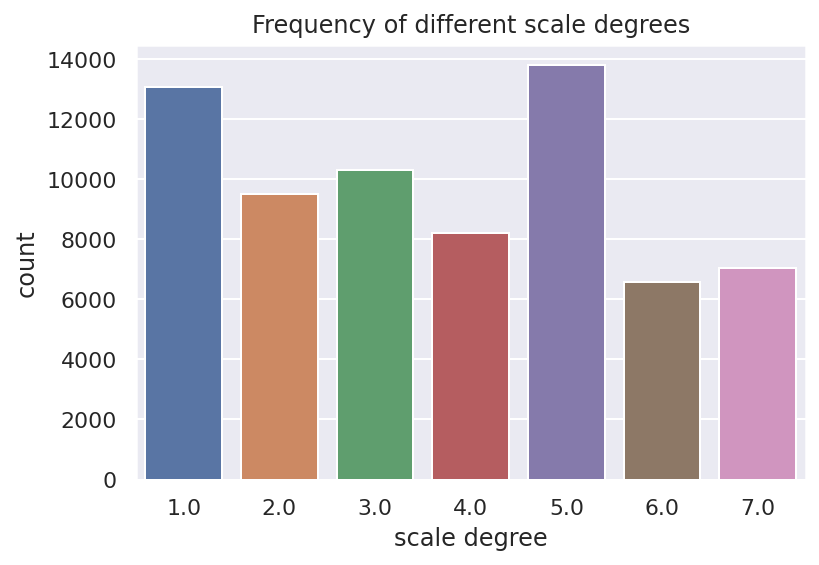

In [10]:
fig, ax = plt.subplots()

sns.countplot(x='degree', data=df)
ax.set(title='Frequency of different scale degrees', xlabel='scale degree');

As per above, the pitch D#/E- appears the most frequently (in total, 80% of the time) in positions VI, IV or VII, which are the degrees that appear the least frequently. By contrast, D appears in positions V, I and III in more than 54% of the cases. 

In summary, not only does D more frequently belong to the scale that is used to write a chorale, it also occupies a stronger position in that scale.

---
<div id="by_part"></div>

## Analysis by parts.

So, does being an alto actually suck? Let's look at pitch distribution for each part. First, here are some figures:

In [12]:
parts=['Soprano', 'Alto', 'Tenor', 'Bass']
soprano, alto, tenor, bass = [df.loc[df['part'] == part] for part in parts]

In [13]:
for part in parts:

    df_part = df.loc[df['part'] == part]
    unique = len(df_part['pitch_midi'].unique())
    top_pitch = msc.pitch.Pitch(midi=df_part['pitch_midi'].mode()[0])
    avg_pitch = msc.pitch.Pitch(midi=np.round(df_part['pitch_midi'].mean()))
    min_pitch = msc.pitch.Pitch(midi=df_part['pitch_midi'].min())
    max_pitch = msc.pitch.Pitch(midi=df_part['pitch_midi'].max())

    print(f"\n{part.upper()}:\n"
          f"\nDistinct pitches: \t{unique}"
          f"\nLowest pitch: \t\t{min_pitch}"
          f"\nHighest pitch: \t\t{max_pitch}"
          f"\nMost frequent pitch: \t{top_pitch}"
          f"\nAverage pitch: \t\t{avg_pitch}")


SOPRANO:

Distinct pitches: 	22
Lowest pitch: 		A3
Highest pitch: 		A5
Most frequent pitch: 	A4
Average pitch: 		B-4

ALTO:

Distinct pitches: 	22
Lowest pitch: 		F3
Highest pitch: 		D5
Most frequent pitch: 	E4
Average pitch: 		F4

TENOR:

Distinct pitches: 	22
Lowest pitch: 		C3
Highest pitch: 		A4
Most frequent pitch: 	A3
Average pitch: 		B3

BASS:

Distinct pitches: 	29
Lowest pitch: 		C2
Highest pitch: 		E4
Most frequent pitch: 	D3
Average pitch: 		E-3


Both middle voices (Alto and Tenor) display a smaller range (one octave and a sixth), as they generally don't need to cover the extremes. Sopranos cover up to a fifth above the highest alto note, while basses can go _a full friggin octave_ below the lowest tenor pitch.

Note: The fact that altos always sing G's is a lie. They always sing E's.

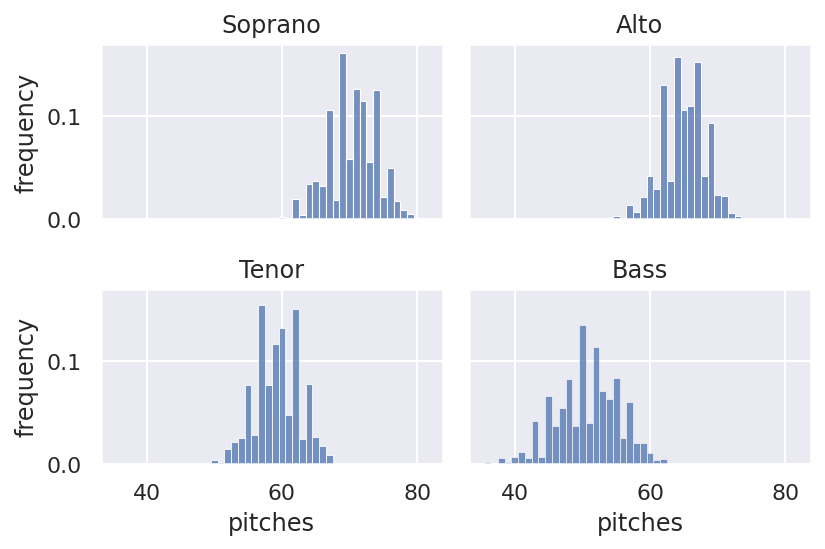

In [14]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True)

for i in range(4):
    ax = axes.flat[i]
    sns.histplot(data=df.loc[df['part'] == parts[i]]['pitch_midi'], ax=ax, discrete=True, stat='density')
    ax.set(title=parts[i], xlabel='pitches', ylabel='frequency')
    
fig.tight_layout()

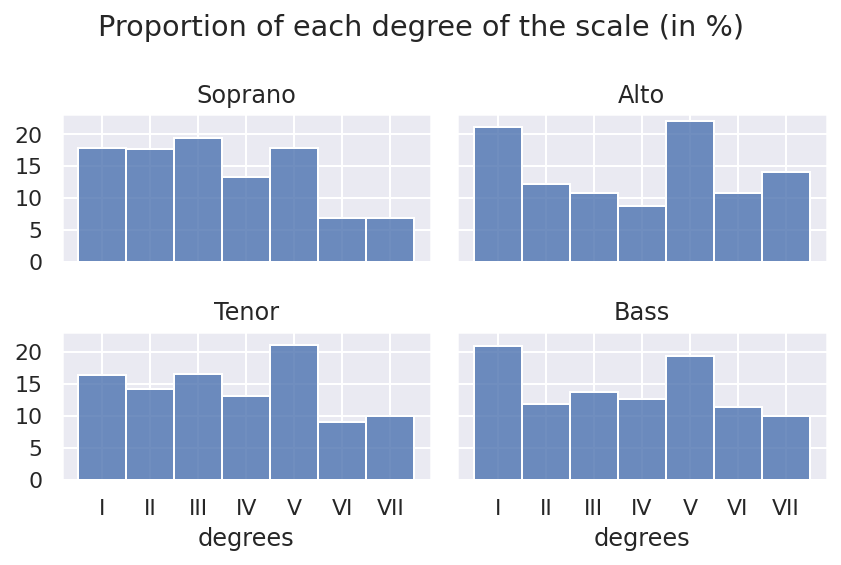

In [15]:
parts=['Soprano', 'Alto', 'Tenor', 'Bass']
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True)

for i in range(4):
    ax = axes.flat[i]
    sns.histplot(data=df.loc[df['part'] == parts[i]]['degree'], ax=ax, discrete=True, stat='density', alpha=0.8, zorder=1)
    #sns.histplot(x='degree', data=df, alpha=1, ax=ax, stat='density', discrete=True, color='gray', zorder=0.6)
    ax.set(title=parts[i], xlabel='degrees', ylabel='', 
           xticks=range(1,8), xticklabels=['I', 'II', 'III', 'IV', 'V', 'VI', 'VII'],
           yticks=np.arange(0, 0.25, 0.05), yticklabels=["0", "5", "10", "15", "20"])

    
plt.suptitle('Proportion of each degree of the scale (in %)')   
fig.tight_layout()

A few observations:
 - Soprano have a somewhat surprising (to me) graph, where notes are evenly distributed across degrees I, II, III and V. They also are the only ones who sing II's more than 15% of the time. I have no explanation for this so I might ask someone.
 - Altos and Basses have pretty similar-looking histograms, with lots of tonics and dominants. 
 - Altos are the only ones to sing VIIs more than 10% of the time; if V7's sound good, it's thanks to altos.
 - The tenor graph looks very similar to the average distribution of degrees across a scale in any given Bach chorale (does that make tenor the canonical voice?)

What about notes that are _not_ part of the scale? Alto end up singing around 37% of these foreign notes, and they make up 10% of alto's total singing time. In contrast, basses have 29% of them, tenors 24% and sopranos, just 10%.

In [16]:
print("Proportion of foreign notes sang by each voice:")
for part in parts:
    if part == 'Soprano':
        print(f"{part}: \t{df.loc[df['degree'].isna()]['part'].value_counts(normalize=True)[part] * 100:.0f}%")
    else:
        print(f"{part}: \t\t{df.loc[df['degree'].isna()]['part'].value_counts(normalize=True)[part] * 100:.0f}%")


print("\nProportion of foreign notes in each part:")
for part in parts:
    df_part = df.loc[df['part'] == part]
    prop = len(df_part.loc[df_part['degree'].isna()]) / len(df_part)
    if part == 'Soprano':
        print(f"{part}: \t{prop * 100:.0f}%")
    else:
        print(f"{part}: \t\t{prop * 100:.0f}%")

Proportion of foreign notes sang by each voice:
Soprano: 	10%
Alto: 		37%
Tenor: 		24%
Bass: 		29%

Proportion of foreign notes in each part:
Soprano: 	3%
Alto: 		10%
Tenor: 		6%
Bass: 		8%
